<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Erin/trained_European_Call_jax_1stock_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T):
  return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.0807]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.2597*0.2597
initial_stocks = jnp.array([0.7178]*numstocks) # must be float
T = 1.0
K = 0.2106

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))
#%timeit optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T)

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))
#%timeit goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T)

0.5236568
[1.0001798]


# Construct Neural Net

In [2]:
%%writefile cupy_dataset.py
# version 1, 2, 6
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
    return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

###################################################################################################
# these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
###################################################################################################

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          rng = jax.random.PRNGKey(self.seed)
          rng, key = jax.random.split(rng)

          ################################################################################################### generate random input numbers

          initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 1.0)

          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.3)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

          r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
          drift = r

          T = self.T
          K = np.random.random(1) * 1.0

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas
          
          keys = jax.random.split(key, self.N_PATHS)

          European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
          gooptionvalue = jax.grad(optionvalueavg, argnums=1)
          Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price
          Y[op, 1:] = cupy.array(Deltas, dtype=cupy.float32) # remember to change this!

          # T, K, S, sigma, mu, r
          paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 1000000, batch = 2, seed = 15, stocks=1) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Overwriting cupy_dataset.py


In [3]:
# %%writefile cupy_dataset.py
# # version 3, 4, 5, 7
# import cupy
# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# from torch.utils.dlpack import from_dlpack

# def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
#     stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
#     stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
#                             jax.ops.index[0],         # initialization of stock prices
#                             initial_stocks)
#     noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
#     sigma = jnp.diag(cov) ** 0.5
#     dt = T / numsteps
#     def time_step(t, val):
#         #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
#         dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
#         val = jax.ops.index_update(val,
#                             jax.ops.index[t],
#                             val[t-1] * dx2)
#         return val
#     return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

# def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
#     return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))
#     # must use '-1' not 'numsteps', or else grad will be 0

# ###################################################################################################
# # these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
# ###################################################################################################

# class OptionDataSet(object):
    
#     def __init__(self, max_len, number_path, batch, seed, stocks):
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 50
#         self.N_BATCH = batch
#         self.N_STOCKS = stocks
#         self.T = 1.0 # assume T = 1, use float here
#         self.seed = seed
#         np.random.seed(seed)
        
#     def __len__(self):
#         return self.max_length
        
#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num >= self.max_length:
#             raise StopIteration
        
#         Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
#         X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

#         for op in range(self.N_BATCH):
          
#           rng = jax.random.PRNGKey(self.seed)
#           rng, key = jax.random.split(rng)

#           ################################################################################################### generate random input numbers

#           initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 200.0)

#           corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
#           sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.4)
#           cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

#           r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
#           drift = r # To match BS, use drift = r

#           T = self.T
#           K = np.random.random(1) * 200.0

#           ###################################################################################################
#           ################################################################################################### apply functions to compute price and deltas
          
#           keys = jax.random.split(key, self.N_PATHS)

#           European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
#           gooptionvalue = jax.grad(optionvalueavg, argnums=1)
#           Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

#           ###################################################################################################
#           ################################################################################################### store input and output numbers in X and Y

#           Y[op, 0] = European_Call_price
#           Y[op, 1:] = cupy.array(Deltas, dtype=cupy.float32)

#           paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
#           paras = np.column_stack(paras).reshape(1,-1)[0]
#           X[op,] = cupy.array(paras)

#           ###################################################################################################

#         self.num += 1
#         return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# # ds = OptionDataSet(max_len = 2, number_path = 10000, batch = 2, seed = 15, stocks=3) # for testing purpose, use constant seed. When training, change to random seed
# # for i in ds:
# #     print(i)

In [4]:
# #%%writefile cupy_dataset.py
# import cupy
# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# from torch.utils.dlpack import from_dlpack

# def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
#     stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
#     stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
#                             jax.ops.index[0],         # initialization of stock prices
#                             initial_stocks)
#     noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
#     sigma = jnp.diag(cov) ** 0.5
#     dt = T / numsteps
#     def time_step(t, val):
#         dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
#         val = jax.ops.index_update(val,
#                             jax.ops.index[t],
#                             val[t-1] * dx)
#         return val
#     return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

# def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
#     return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

# ###################################################################################################
# # these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
# ###################################################################################################

# class OptionDataSet(object):
    
#     def __init__(self, max_len, number_path, batch, stocks):
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 50
#         self.N_BATCH = batch
#         self.N_STOCKS = stocks
#         self.T = 1.0 # assume T = 1, use float here
#         # self.seed = seed
#         # np.random.seed(seed)
        
#     def __len__(self):
#         return self.max_length
        
#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num >= self.max_length:
#             raise StopIteration
        
#         Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
#         X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

#         for op in range(self.N_BATCH):
          
#           np.random.seed(np.random.randint(10000))
#           rng = jax.random.PRNGKey(np.random.randint(10000))
#           rng, key = jax.random.split(rng)

#           ################################################################################################### generate random input numbers

#           initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 1.0)

#           corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
#           sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.3)
#           cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

#           r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
#           drift = jnp.array(np.random.random(self.N_STOCKS) * 0.1)

#           T = self.T
#           K = np.random.random(1) * 1.0

#           ###################################################################################################
#           ################################################################################################### apply functions to compute price and deltas
          
#           keys = jax.random.split(key, self.N_PATHS)

#           European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
#           gooptionvalue = jax.grad(optionvalueavg, argnums=1)
#           Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

#           ###################################################################################################
#           ################################################################################################### store input and output numbers in X and Y

#           Y[op, 0] = European_Call_price
#           Y[op, 1:4] = cupy.array(Deltas, dtype=cupy.float32)

#           # T, K, S, sigma, mu, r
#           paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
#           paras = np.column_stack(paras).reshape(1,-1)[0]
#           X[op,] = cupy.array(paras)

#           ###################################################################################################

#         self.num += 1
#         return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 10000, batch = 2, stocks=3) # When training, change to random seed
# for i in ds:
#     print(i)

In [5]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 1.0, 1.0, 0.3, 0.1, 0.1]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


In [6]:
# %%writefile model.py
# # version 3,7
# import torch.nn as nn
# import torch.nn.functional as F
# import torch
# import numpy as np

# class Net(nn.Module):

#     def __init__(self, hidden=1024):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(6*1, hidden) # remember to change this!
#         self.fc2 = nn.Linear(hidden, hidden)
#         self.fc3 = nn.Linear(hidden, hidden)
#         self.fc4 = nn.Linear(hidden, hidden)
#         self.fc5 = nn.Linear(hidden, hidden)
#         self.fc6 = nn.Linear(hidden, 1) # 1 outputs: price
#         self.register_buffer('norm',
#                              torch.tensor([1, 200.0, 200.0, 0.4, 0.1, 0.1]*1)) # don't use numpy here - will give error later
#                                                                                # T, K, S, sigma, mu, r

#     def forward(self, x):
#         # normalize the parameter to range [0-1] 
#         x = x / self.norm
#         x = F.elu(self.fc1(x))
#         x = F.elu(self.fc2(x))
#         x = F.elu(self.fc3(x))
#         x = F.elu(self.fc4(x))
#         x = F.elu(self.fc5(x))
#         return self.fc6(x)

In [7]:
# # version 4, 5
# %%writefile model.py
# import torch.nn as nn
# import torch.nn.functional as F
# import torch
# import numpy as np

# class Net(nn.Module):

#     def __init__(self, hidden=1024):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(6*1, hidden) # remember to change this!
#         self.fc2 = nn.Linear(hidden, hidden)
#         self.fc3 = nn.Linear(hidden, hidden)
#         self.fc4 = nn.Linear(hidden, hidden)
#         self.fc5 = nn.Linear(hidden, hidden)
#         self.fc6 = nn.Linear(hidden, 2) # 2 outputs: price, delta
#         self.register_buffer('norm',
#                              torch.tensor([1, 200.0, 200.0, 0.4, 0.1, 0.1]*1)) # don't use numpy here - will give error later
#                                                                                # T, K, S, sigma, mu, r

#     def forward(self, x):
#         # normalize the parameter to range [0-1] 
#         x = x / self.norm
#         x = F.elu(self.fc1(x))
#         x = F.elu(self.fc2(x))
#         x = F.elu(self.fc3(x))
#         x = F.elu(self.fc4(x))
#         x = F.elu(self.fc5(x))
#         return self.fc6(x)

In [8]:
# # version 6
# %%writefile model.py
# import torch.nn as nn
# import torch.nn.functional as F
# import torch
# import numpy as np

# class Net(nn.Module):

#     def __init__(self, hidden=1024):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(6*1, hidden) # remember to change this!
#         self.fc2 = nn.Linear(hidden, hidden)
#         self.fc3 = nn.Linear(hidden, hidden)
#         self.fc4 = nn.Linear(hidden, hidden)
#         self.fc5 = nn.Linear(hidden, hidden)
#         self.fc6 = nn.Linear(hidden, 2) # 2 outputs: price, delta
#         self.register_buffer('norm',
#                              torch.tensor([1.0, 1.0, 1.0, 0.3, 0.1, 0.1]*1)) # don't use numpy here - will give error later
#                                                                                # T, K, S, sigma, mu, r

#     def forward(self, x):
#         # normalize the parameter to range [0-1] 
#         x = x / self.norm
#         x = F.elu(self.fc1(x))
#         x = F.elu(self.fc2(x))
#         x = F.elu(self.fc3(x))
#         x = F.elu(self.fc4(x))
#         x = F.elu(self.fc5(x))
#         return self.fc6(x)

# Train Neural Net

In [9]:
!pip install pytorch-ignite

In [10]:
# # version 1 & version 3 (200)
# # If memory is not enough, try changing parameters and restarting session
# # loss will converge

# from ignite.engine import Engine, Events
# from ignite.handlers import Timer
# from torch.nn import MSELoss
# from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
# from ignite.handlers import ModelCheckpoint
# from model import Net
# from cupy_dataset import OptionDataSet
# import numpy as np
# timer = Timer(average=True)
# model = Net().cuda()
# loss_fn = MSELoss()
# optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = OptionDataSet(max_len = 100, number_path = int(1e6), batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed


# def train_update(engine, batch):
#     model.train()
#     optimizer.zero_grad()
#     x = batch[0]
#     y = batch[1]
#     y = y[:,0].reshape(-1,1)
#     #print(y)
#     y_pred = model(x)
#     #print(y_pred)
#     loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
#     #print(loss)
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# trainer = Engine(train_update)
# log_interval = 20

# scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
# trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
# timer.attach(trainer,
#              start=Events.EPOCH_STARTED,
#              resume=Events.ITERATION_STARTED,
#              pause=Events.ITERATION_COMPLETED,
#              step=Events.ITERATION_COMPLETED)    
# @trainer.on(Events.ITERATION_COMPLETED)
# def log_training_loss(engine):
#     iter = (engine.state.iteration - 1) % len(dataset) + 1
#     if iter % log_interval == 0:
#         print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
# trainer.run(dataset, max_epochs = 100)

In [11]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 100000, batch = 8, seed = np.random.randint(10000), stocks = 1) # must have random seed

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 0]).cuda()  # let delta weight = 0 for testing
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  if __name__ == '__main__':


loss 0.013804377056658268 average time 0.20097316244996363 iter num 20
loss 0.013547497801482677 average time 0.10784878504999824 iter num 40
loss 0.015108984895050526 average time 0.0768151311666467 iter num 60
loss 0.008190256543457508 average time 0.06126157638748282 iter num 80
loss 0.01769290119409561 average time 0.05192215447998933 iter num 100
loss 0.02364984340965748 average time 0.03646207305002917 iter num 20
loss 0.01126737892627716 average time 0.025683993675067997 iter num 40
loss 0.015724733471870422 average time 0.02225810866671812 iter num 60
loss 0.005341275129467249 average time 0.020356744412532636 iter num 80
loss 0.0055426666513085365 average time 0.01933542493002278 iter num 100
loss 0.016154490411281586 average time 0.0367463811999869 iter num 20
loss 0.002646077424287796 average time 0.025774725599967498 iter num 40
loss 0.004602628760039806 average time 0.022021366599968437 iter num 60
loss 0.004555930383503437 average time 0.02020826411246617 iter num 80
loss

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
# # version 4
# # If memory is not enough, try changing parameters and restarting session
# # loss will converge

# from ignite.engine import Engine, Events
# from ignite.handlers import Timer
# from torch.nn import MSELoss
# from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
# from ignite.handlers import ModelCheckpoint
# from model import Net
# from cupy_dataset import OptionDataSet
# import numpy as np
# timer = Timer(average=True)
# model = Net().cuda()
# loss_fn = MSELoss()
# optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed


# def train_update(engine, batch):
#     model.train()
#     optimizer.zero_grad()
#     x = batch[0]
#     y = batch[1]
#     #print(y)
#     y_pred = model(x)
#     #print(y_pred)
#     loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
#     #print(loss)
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# trainer = Engine(train_update)
# log_interval = 20

# scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
# trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
# timer.attach(trainer,
#              start=Events.EPOCH_STARTED,
#              resume=Events.ITERATION_STARTED,
#              pause=Events.ITERATION_COMPLETED,
#              step=Events.ITERATION_COMPLETED)    
# @trainer.on(Events.ITERATION_COMPLETED)
# def log_training_loss(engine):
#     iter = (engine.state.iteration - 1) % len(dataset) + 1
#     if iter % log_interval == 0:
#         print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
# trainer.run(dataset, max_epochs = 100)

In [ ]:
# # version 5, 6
# # If memory is not enough, try changing parameters and restarting session
# # loss will converge

# from ignite.engine import Engine, Events
# from ignite.handlers import Timer
# from torch.nn import MSELoss
# from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
# from ignite.handlers import ModelCheckpoint
# from model import Net
# from cupy_dataset import OptionDataSet
# import numpy as np
# timer = Timer(average=True)
# model = Net().cuda()
# loss_fn = MSELoss()
# optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = OptionDataSet(max_len = 100, number_path = 100000, batch =32, seed = np.random.randint(10000), stocks = 1) # must have random seed


# def train_update(engine, batch):
#     model.train()
#     optimizer.zero_grad()
#     x = batch[0]
#     y = batch[1]
#     #print(y)
#     y_pred = model(x)
#     #print(y_pred)
#     loss = ((y_pred - y) ** 2).mean(axis=0).sum()
#     #print(loss)
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# trainer = Engine(train_update)
# log_interval = 20

# scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
# trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
# timer.attach(trainer,
#              start=Events.EPOCH_STARTED,
#              resume=Events.ITERATION_STARTED,
#              pause=Events.ITERATION_COMPLETED,
#              step=Events.ITERATION_COMPLETED)    
# @trainer.on(Events.ITERATION_COMPLETED)
# def log_training_loss(engine):
#     iter = (engine.state.iteration - 1) % len(dataset) + 1
#     if iter % log_interval == 0:
#         print('loss', engine.state.output * 10000, 'average time', timer.value(), 'iter num', iter) # * 10000 for version 6
        
# trainer.run(dataset, max_epochs = 50)

**Save Model**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import torch
model_save_name = 'new_european_1stock_v2.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import torch
model_save_name = 'new_european_1stock_v2.pth'
path = F"/content/drive/MyDrive/AFP/Save_Models/{model_save_name}"
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [16]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=6, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1, bias=True)
)


**Continue to train model**

In [ ]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 8, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 0]).cuda()  # let delta weight = 0 for testing
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output * 10000, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 30)

model_save_name = 'jax_european_1stock_test_3.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
# # version 4
# # If memory is not enough, try changing parameters and restarting session
# # loss will converge

# from ignite.engine import Engine, Events
# from ignite.handlers import Timer
# from torch.nn import MSELoss
# from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
# from ignite.handlers import ModelCheckpoint
# from model import Net
# from cupy_dataset import OptionDataSet
# import numpy as np
# timer = Timer(average=True)
# loss_fn = MSELoss()
# optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 8, seed = np.random.randint(10000), stocks = 1) # must have random seed


# def train_update(engine, batch):
#     model.train()
#     optimizer.zero_grad()
#     x = batch[0]
#     y = batch[1]
#     #print(y)
#     y_pred = model(x)
#     #print(y_pred)
#     loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
#     #print(loss)
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# trainer = Engine(train_update)
# log_interval = 20

# scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
# trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
# timer.attach(trainer,
#              start=Events.EPOCH_STARTED,
#              resume=Events.ITERATION_STARTED,
#              pause=Events.ITERATION_COMPLETED,
#              step=Events.ITERATION_COMPLETED)    
# @trainer.on(Events.ITERATION_COMPLETED)
# def log_training_loss(engine):
#     iter = (engine.state.iteration - 1) % len(dataset) + 1
#     if iter % log_interval == 0:
#         print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
# trainer.run(dataset, max_epochs = 50)

# model_save_name = 'jax_european_1stock_version4_2.pth'
# path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
# torch.save(model.state_dict(), path)

In [ ]:
# # version 5
# # If memory is not enough, try changing parameters and restarting session
# # loss will converge

# from ignite.engine import Engine, Events
# from ignite.handlers import Timer
# from torch.nn import MSELoss
# from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
# from ignite.handlers import ModelCheckpoint
# from model import Net
# from cupy_dataset import OptionDataSet
# import numpy as np
# timer = Timer(average=True)
# loss_fn = MSELoss()
# optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 8, seed = np.random.randint(10000), stocks = 1) # must have random seed


# def train_update(engine, batch):
#     model.train()
#     optimizer.zero_grad()
#     x = batch[0]
#     y = batch[1]
#     #print(y)
#     y_pred = model(x)
#     #print(y_pred)
#     loss = ((y_pred - y) ** 2).mean(axis=0).sum()
#     #print(loss)
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# trainer = Engine(train_update)
# log_interval = 20

# scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
# trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
# timer.attach(trainer,
#              start=Events.EPOCH_STARTED,
#              resume=Events.ITERATION_STARTED,
#              pause=Events.ITERATION_COMPLETED,
#              step=Events.ITERATION_COMPLETED)    
# @trainer.on(Events.ITERATION_COMPLETED)
# def log_training_loss(engine):
#     iter = (engine.state.iteration - 1) % len(dataset) + 1
#     if iter % log_interval == 0:
#         print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
# trainer.run(dataset, max_epochs = 20)

# model_save_name = 'jax_european_1stock_version5_1.pth'
# path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
# torch.save(model.state_dict(), path)

In [ ]:
a = np.array([[2.5661e+01, 9.5063e-01],
        [6.5737e-07, 3.5066e-06]])
b = np.array([[32.7189,  0.9209],
        [ 1.5464,  0.3001]])
((a-b)**2).mean(axis=0).sum()

#Results

In [17]:
import torch
inputs = torch.tensor([[1, 0.8, 0.8, 0.25, 0.05, 0.05]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.098688, 0.627409)

price: tensor([[0.0914]], device='cuda:0', grad_fn=<AddmmBackward>)


tensor([0.6244], device='cuda:0')

In [18]:
numstocks = 1
numsteps = 50
numpaths = 1000000
›
rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.05]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([0.8]*numstocks) # must be float
T = 1.0
K = 0.8

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))

0.09876674
[0.62784874]


In [19]:
import torch
inputs = torch.tensor([[1, 110.0, 100.0, 0.25, 0.05, 0.05]]).cuda() # T, K, S, sigma, mu, r
print('price, delta: ' + str(model(inputs.float())))

# inputs.requires_grad = True
# x = model(inputs.float())
# x.backward()
# first_order_gradient = inputs.grad
# first_order_gradient[0][[2]]

# should be 8.058, 0.478

price, delta: tensor([[4.5221]], device='cuda:0', grad_fn=<AddmmBackward>)


In [20]:
numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.05]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([100.0]*numstocks) # must be float
T = 1.0
K = 110.0

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))

8.029676
[0.47848195]


# Delta

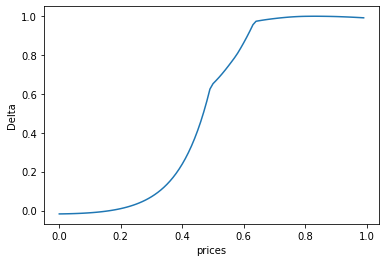

In [21]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[1, 0.5, S, 0.25, 0.05, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(0, 1, 0.01)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

In [23]:
# import pylab
# import numpy as np
# prices = np.arange(0, 200, 1)
# deltas = []
# for p in prices:
#     inputs = torch.tensor([[1, 110.0, p, 0.25, 0.05, 0.05]]).cuda() # T, K, S, sigma, mu, r
#     deltas.append(model(inputs.float())[0][1])
# fig = pylab.plot(prices, deltas)
# pylab.xlabel('prices')
# pylab.ylabel('Delta')
# fig